# <div style="text-align:center; color:rgba(37, 40, 80);">11752 Machine Learning</div>
# <div style="text-align:center; color:rgba(37, 40, 80);">Master in Intelligent Systems</div>
# <div style="text-align:center; color:rgba(37, 40, 80);">Universitat de les Illes Balears</div>

### <div style="text-align:center; color:white;"> Handout #2: **Supervised learning**</div>

#### **Integrants:** Jason Adel Noboa Rivera, Pedro Marti Pico
#### **Group:** 07

##### T1. **Given dataset dsgg1.txt:**

a)	Solve for the SVM analytically using the Karush-Kuhn-Tucker conditions and the Wolfe dual representation making use of the quadratic programming solver and:

•	find and report the support vectors (NOTE: due to round-off errors, it is likely none of the λ_i are exactly 0, but close, e.g. 10^(-6)), and

•	calculate and report the resulting decision function g(x)=w^T x+w_0.



In [13]:
import numpy as np
import cvxpy as cp
from sklearn import svm

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

In [30]:
'''
1. commented source code
2. support vectors
3. decision function 
'''
group = '07' 

task = 1
data = np.loadtxt('ds'+group+str(task)+'.txt')
X = data[:,0:2]
y = data[:,2:3] #CLass labels are 1 for w1 and 0 for w2
y = np.squeeze(y)


In [29]:
X

array([[ 0.58826146, -4.43327739],
       [-0.82782933, -0.56098003],
       [-3.89957879,  2.18935727],
       [-1.92250797, -2.51076943],
       [-4.16642809,  0.8005479 ],
       [-3.60544806, -0.02728143],
       [-2.2166387 , -0.29413073],
       [-0.5336986 , -2.77761873],
       [ 1.65565867,  1.12196006],
       [-1.41609079,  3.87229736],
       [ 0.2668493 ,  1.38880936],
       [ 3.60544806,  0.02728143],
       [ 1.36152793,  3.33859876],
       [-0.02728143,  3.60544806],
       [ 1.09467863,  1.9497894 ],
       [-0.58826146,  4.43327739]])

b)	Generate the following plots:

•	a first plot with the training samples, highlighting the support vectors and plotting the 2D decision curve

•	a second plot with the classification map, i.e. evaluate the decision function for a 'regular' subset (grid) of points of the feature space
Use different markers and/or colours for each class.


In [ ]:
'''
1. commented source code
2. plot with samples and contour corresponding to the decision function
3. classification map
'''

c)	Compare the results obtained with the ones resulting from the scikit-learn SVC object: i.e. report the support vectors returned by SVC and the corresponding decision function.

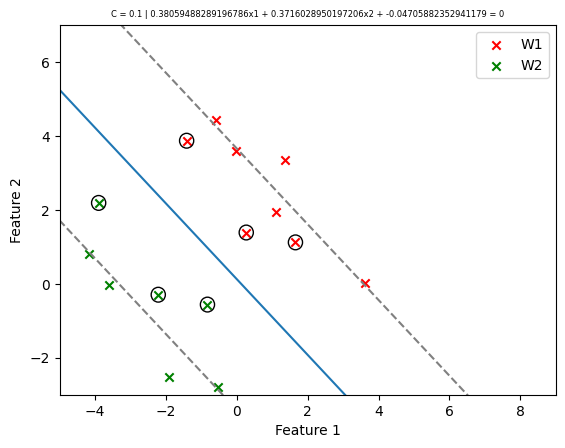

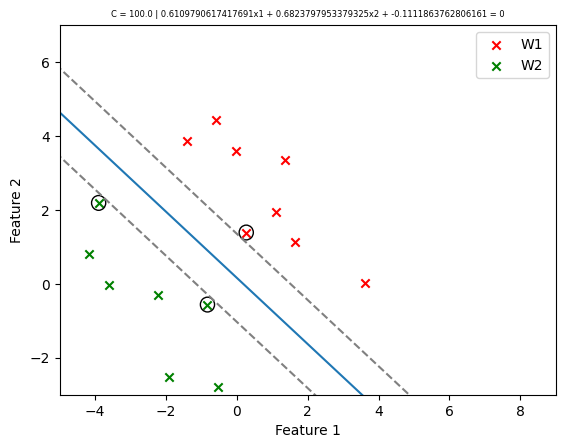

In [31]:
'''
1. commented source code
2. support vectors
3. decision function
4. plot with samples and contour corresponding to the decision function
5. classification map
'''

Cs = [0.1, 100.0]

for C in Cs:
    clf = svm.SVC(C = C, kernel = 'linear')
    clf.fit(X, y)

    sv = clf.support_vectors_
    w = clf.coef_.flatten()
    w0 = clf.intercept_
    lm = clf.dual_coef_.flatten()

    '''Plot the samples'''
    # assuming X is your data and y are your labels
    X1 = X[y == 1.0]  # points of class w1
    X2 = X[y == 0.0]  # points of class w2

    plt.scatter(X1[:, 0], X1[:, 1], color='red', marker='x', label='W1')  # plot points of class 0
    plt.scatter(X2[:, 0], X2[:, 1], color='green', marker='x', label='W2')  # plot points of class 1

    '''Add the circles in supported vector machines'''
    for loc in sv:
        px, py = loc
        circle = Circle((px,py), 0.2, fill=False)
        plt.gca().add_patch(circle)

    # set the limits of the axes
    plt.xlim([-5, 9])
    plt.ylim([-3, 7])

    '''Add the decision curve'''
    x_values = np.linspace(-10, 10, 10)

    # calculate corresponding y values
    y_values = (-w[0] / w[1]) * x_values - w0[0] / w[1]

    '''Add the segmented lines'''
    #Calculate the distance of the segmented line: 1/||w||
    d = 1/np.linalg.norm(w) 

    # calculate y values for the segmented lines
    y_values_segmented_line1 = y_values + d / np.sqrt(w[0]**2 + w[1]**2)
    y_values_segmented_line2 = y_values - d / np.sqrt(w[0]**2 + w[1]**2)

    # add the segmented lines to the plot
    plt.plot(x_values, y_values_segmented_line1, '--', color = 'grey')
    plt.plot(x_values, y_values_segmented_line2, '--', color = 'grey')

    # add the line to the plot
    plt.plot(x_values, y_values)


    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(f'C = {C} | {w[0]}x1 + {w[1]}x2 + {w0[0]} = 0', fontsize = 6 )
    plt.legend()
    plt.show()